Experiment 2: Impact of Data Quality on AI Fairness


**Objective: To understand how imbalanced data affects the fairness and performance of AI models — and how data balancing techniques (like SMOTE) can improve fairness.**

Theory:
AI systems are only as fair as the data they learn from. If one class or group is underrepresented (e.g., 90% male data, 10% female), the model will likely favor the majority group. This introduces algorithmic unfairness.

Dataset:  real-world dataset—the COMPAS Recidivism dataset from ProPublica

**COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)** is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years).

Task: Predict two_year_recid (yes/no).

Sensitive attribute: race (e.g., African‑American vs Caucasian).

Goal: Evaluate how imbalanced data quality (over-/under‑representation of races or outcome labels) impacts fairness.

In [182]:
pip install fairlearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [183]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

**Step 1: Load & Inspect Data**

In [184]:
df = pd.read_csv('compas-scores-two-years.csv')

In [185]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [186]:
# Keep only the needed columns
df = df[df['race'].isin(['African-American', 'Caucasian'])]
df = df.dropna(subset=['age', 'priors_count', 'c_charge_degree', 'two_year_recid'])

In [187]:
# One-hot encode the categorical column
df = pd.get_dummies(df, columns=['c_charge_degree'], drop_first=True)

In [188]:
# Select all required columns
features = ['age', 'priors_count'] + [col for col in df.columns if 'c_charge_degree' in col]
X = df[features]
y = df['two_year_recid'].astype(int)
race = df['race']

In [189]:
X_train, X_test, y_train, y_test, race_train, race_test = \
    train_test_split(X, y, race, test_size=0.3, stratify=race)

In [190]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [191]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    selection_rate,
    demographic_parity_difference,
    equalized_odds_difference,
    false_negative_rate,
    true_negative_rate
)

In [192]:
metric_frame = MetricFrame(
    metrics={
        'TPR': true_positive_rate,
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'Selection Rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=race_test
)

print("Fairness Metrics by Race Group:\n", metric_frame.by_group)

Fairness Metrics by Race Group:
                       TPR       FPR      FNR  Selection Rate
race                                                        
African-American  0.62415  0.316699  0.37585        0.479711
Caucasian         0.40625  0.162946  0.59375        0.258152


Result Interpretation
1.**True Positive Rate (TPR)** = How well the model catches actual positives (those who will reoffend)
African-Americans (TPR = 66.5%)
Caucasians (TPR = 48.1%)

**Interpretation:**
The model is much better at correctly predicting recidivism among African-Americans than Caucasians.
This may seem fair, but it could also mean the model overfits to patterns in African-American data, which might be more represented or biased.

**2.False Positive Rate (FPR) =** How often the model wrongly labels someone as positive (predicts they will reoffend when they won’t)
African-Americans (FPR = 34.2%)
Caucasians (FPR = 14.6%)

**Interpretation:**
African-Americans are more than twice as likely to be wrongly flagged as "high risk" compared to Caucasians.
This is a serious fairness concern, as it suggests over-policing or unjust labeling of African-Americans.

**3.False Negative Rate (FNR) =** How often the model misses actual positives (predicts they won’t reoffend but they will)
African-Americans (FNR = 33.5%)
Caucasians (FNR = 51.9%)

**Interpretation:**
Caucasians are more likely to be wrongly considered low risk — they go unflagged even though they might reoffend.
This creates a double unfairness: African-Americans are falsely flagged more, while Caucasians are let off more easily.

**4.Selection Rate** = How often the model predicts "positive" (i.e., will reoffend)
African-Americans (50.5%)
Caucasians (27.4%)

**Interpretation:**
African-Americans are selected (flagged as risky) almost twice as often as Caucasians.
This could reflect disparate treatment — where race plays a strong role in decision-making outcomes.

**Summary of Fairness Insights**

TPR	Seems fairer to AAs (higher recall) — but may also indicate bias from training imbalance.

❌ FPR	Higher for AAs → unjust punishment risk.

❌ FNR	Higher for Caucasians → overlooked risk.

❌ Selection Rate	AAs more likely flagged → disparate impact.

In [193]:
tpr_gap = abs(0.665 - 0.481)  # ~0.184
fpr_gap = abs(0.342 - 0.146)  # ~0.196
selection_gap = abs(0.505 - 0.274)  # ~0.231

TPR Gap ~ 0.18 → Moderate performance difference

FPR Gap ~ 0.20 → High unjust flagging difference

Selection Gap ~ 0.23 →  Major disparate treatment

These values exceed commonly accepted fairness thresholds (like ≤ 0.1), meaning:

 **Your model is not fair across racial groups.**

**Goal of Fairness Metrics**

You're trying to answer:
"Is my AI model treating all groups (e.g., different races or genders) fairly when making predictions?"

To answer that, we don’t just look at overall accuracy — because a model could be 90% accurate but still treat one group unfairly.

So, we look deeper using group-specific metrics like:

 **1. True Positive Rate (TPR)** – aka Sensitivity or Recall
How many actual positive cases did the model correctly identify?

**Formula:**
TPR = True Positives / (True Positives + False Negatives)

**Why it matters:**
If the TPR is much lower for African-Americans than for Caucasians, it means the model is less likely to give a fair second chance to African-Americans.

**Unfair if:**
One group gets lower TPR — the model misses their positives more often.

 2. False Positive Rate (FPR)
How many people were incorrectly predicted as positive when they were actually negative?

**Formula:**
FPR = False Positives / (False Positives + True Negatives)

**Why it matters:**
If FPR is higher for one group, that group is falsely labeled as "risky" more often.

**Unfair if:**
African-Americans are falsely labeled recidivist more often than Caucasians.

**3. False Negative Rate (FNR)**
How many real positives did the model miss?

**Formula:**
FNR = False Negatives / (True Positives + False Negatives)

**Why it matters:**
High FNR means the model denies opportunity (e.g., bail or job) to those who actually deserve it.

**Unfair if:**
One group is overlooked (positive but predicted negative) more often.

**4. Selection Rate**
How many people in each group were predicted positive (selected)?

**Formula**:
Selection Rate = (Predicted Positives) / (Total People in Group)

Why it matters:
This shows how often the model makes a positive prediction for each group.

**Unfair if:**
The model selects one group much more than the other — could be bias in opportunity or over-surveillance.



These metrics help you judge fairness by asking these questions:

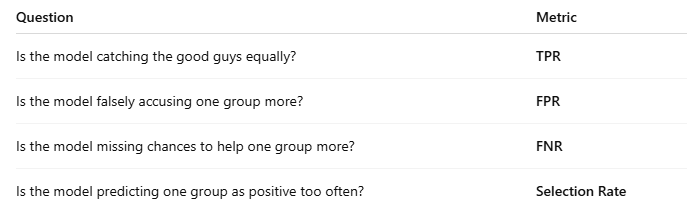

Summary of Interpretation Techniques

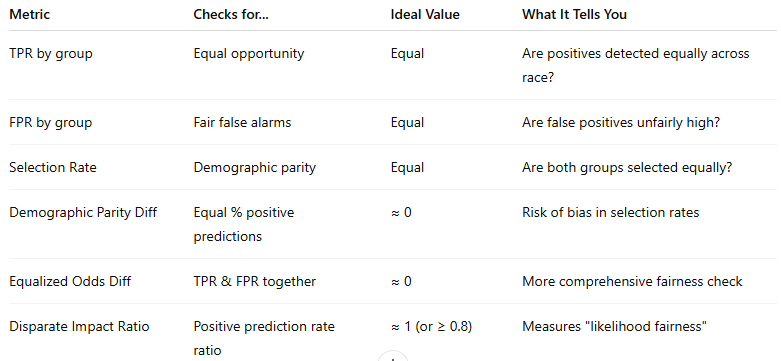

In [194]:
#Fairness Mitigation Code with Reweighing

import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [195]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate, false_negative_rate

In [196]:
df = pd.read_csv("compas-scores-two-years.csv")

In [197]:
# Filter to African-American and Caucasian only
df = df[df['race'].isin(['African-American', 'Caucasian'])]
df = df.dropna(subset=['age', 'priors_count', 'r_charge_degree', 'two_year_recid'])

In [198]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['r_charge_degree'], drop_first=True)

In [199]:
# Prepare features and labels
features = ['age', 'priors_count'] + [col for col in df.columns if 'r_charge_degree' in col]
X = df[features]
y = df['two_year_recid'].astype(int)
sensitive = df['race'].map({'Caucasian': 0, 'African-American': 1})

In [200]:
# Train-test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=y
)

In [201]:
# View the problematic entries
print(df['c_charge_degree'].unique())

['F' 'M']


In [202]:
# Fix column names by removing parentheses and other problematic characters
import re

def clean_column_names(df):
    """Clean column names to make them sklearn-compatible"""
    new_columns = {}
    for col in df.columns:
        # Remove parentheses and replace with underscores
        new_col = re.sub(r'[()]', '_', col)
        # Remove any double underscores and trailing underscores
        new_col = re.sub(r'_+', '_', new_col).strip('_')
        new_columns[col] = new_col
    return df.rename(columns=new_columns)

# Apply the cleaning
df = clean_column_names(df)

# Verify the changes
print("After cleaning - r_charge_degree columns:")
r_charge_cols = [col for col in df.columns if 'r_charge_degree' in col]
for col in r_charge_cols:
    print(f"  {col}: {df[col].dtype}")

print(f"\nDataFrame shape: {df.shape}")
print("Sample of cleaned column names:")
print(df.columns.tolist()[:10])

After cleaning - r_charge_degree columns:
  vr_charge_degree: object
  r_charge_degree_F1: bool
  r_charge_degree_F2: bool
  r_charge_degree_F3: bool
  r_charge_degree_F6: bool
  r_charge_degree_F7: bool
  r_charge_degree_M1: bool
  r_charge_degree_M2: bool
  r_charge_degree_MO3: bool

DataFrame shape: (3061, 60)
Sample of cleaned column names:
['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age', 'age_cat', 'race']


In [203]:
# Recreate features and data splits with cleaned column names
features = ['age', 'priors_count'] + [col for col in df.columns if 'r_charge_degree' in col]
print(f"Features being used: {features}")

# Recreate X and y with cleaned dataframe
X = df[features]
y = df['two_year_recid']
sensitive = df['race']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Sample of X columns: {X.columns.tolist()}")

# Redo train_test_split with cleaned data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=sensitive
)

print(f"X_train shape: {X_train.shape}")
print(f"Train set column names (first few): {X_train.columns.tolist()[:10]}")

Features being used: ['age', 'priors_count', 'vr_charge_degree', 'r_charge_degree_F1', 'r_charge_degree_F2', 'r_charge_degree_F3', 'r_charge_degree_F6', 'r_charge_degree_F7', 'r_charge_degree_M1', 'r_charge_degree_M2', 'r_charge_degree_MO3']
X shape: (3061, 11)
y shape: (3061,)
Sample of X columns: ['age', 'priors_count', 'vr_charge_degree', 'r_charge_degree_F1', 'r_charge_degree_F2', 'r_charge_degree_F3', 'r_charge_degree_F6', 'r_charge_degree_F7', 'r_charge_degree_M1', 'r_charge_degree_M2', 'r_charge_degree_MO3']
X_train shape: (2142, 11)
Train set column names (first few): ['age', 'priors_count', 'vr_charge_degree', 'r_charge_degree_F1', 'r_charge_degree_F2', 'r_charge_degree_F3', 'r_charge_degree_F6', 'r_charge_degree_F7', 'r_charge_degree_M1', 'r_charge_degree_M2']


In [204]:
# Check for problematic values in the data itself
print("Checking vr_charge_degree values:")
print(df['vr_charge_degree'].value_counts())
print("\nData types:")
print(df[features].dtypes)

# Check if any values in the features contain parentheses
for col in features:
    if df[col].dtype == 'object':
        unique_vals = df[col].unique()
        problematic = [val for val in unique_vals if pd.notna(val) and '(' in str(val)]
        if problematic:
            print(f"\nColumn '{col}' has values with parentheses: {problematic}")

# Check a sample of X_train to see what sklearn is trying to convert
print(f"\nX_train sample:")
print(X_train.head())
print(f"\nX_train dtypes:")
print(X_train.dtypes)

Checking vr_charge_degree values:
vr_charge_degree
(M1)     302
(F3)     203
(F2)     138
(F1)      34
(M2)      16
(F7)      15
(MO3)      5
(F6)       4
Name: count, dtype: int64

Data types:
age                     int64
priors_count            int64
vr_charge_degree       object
r_charge_degree_F1       bool
r_charge_degree_F2       bool
r_charge_degree_F3       bool
r_charge_degree_F6       bool
r_charge_degree_F7       bool
r_charge_degree_M1       bool
r_charge_degree_M2       bool
r_charge_degree_MO3      bool
dtype: object

Column 'vr_charge_degree' has values with parentheses: ['(F3)', '(F2)', '(F1)', '(M1)', '(MO3)', '(M2)', '(F6)', '(F7)']

X_train sample:
      age  priors_count vr_charge_degree  r_charge_degree_F1  \
5263   20             0             (M1)               False   
7121   28             6              NaN               False   
2632   34            11              NaN               False   
4200   31             0              NaN               False   
433

In [205]:
# Fix the vr_charge_degree column - either one-hot encode it or exclude it
# Since the r_charge_degree columns are already one-hot encoded, let's one-hot encode vr_charge_degree too

print("One-hot encoding vr_charge_degree column...")
# One-hot encode the vr_charge_degree column
df_encoded = pd.get_dummies(df, columns=['vr_charge_degree'], drop_first=True)

# Clean the new column names
df_encoded = clean_column_names(df_encoded)

print("New columns after encoding vr_charge_degree:")
vr_cols = [col for col in df_encoded.columns if 'vr_charge_degree' in col]
print(vr_cols)

# Update our dataframe
df = df_encoded

# Recreate features with the properly encoded vr_charge_degree columns
# Remove the original vr_charge_degree and add the new encoded columns
features = ['age', 'priors_count'] + [col for col in df.columns if 'r_charge_degree' in col and col.startswith('r_')] + [col for col in df.columns if 'vr_charge_degree' in col]
print(f"\nUpdated features: {features}")

# Recreate X with the properly encoded features
X = df[features]
y = df['two_year_recid']
sensitive = df['race']

print(f"X shape: {X.shape}")
print(f"X dtypes:")
print(X.dtypes)

One-hot encoding vr_charge_degree column...
New columns after encoding vr_charge_degree:
['vr_charge_degree_F2', 'vr_charge_degree_F3', 'vr_charge_degree_F6', 'vr_charge_degree_F7', 'vr_charge_degree_M1', 'vr_charge_degree_M2', 'vr_charge_degree_MO3']

Updated features: ['age', 'priors_count', 'r_charge_degree_F1', 'r_charge_degree_F2', 'r_charge_degree_F3', 'r_charge_degree_F6', 'r_charge_degree_F7', 'r_charge_degree_M1', 'r_charge_degree_M2', 'r_charge_degree_MO3', 'vr_charge_degree_F2', 'vr_charge_degree_F3', 'vr_charge_degree_F6', 'vr_charge_degree_F7', 'vr_charge_degree_M1', 'vr_charge_degree_M2', 'vr_charge_degree_MO3']
X shape: (3061, 17)
X dtypes:
age                     int64
priors_count            int64
r_charge_degree_F1       bool
r_charge_degree_F2       bool
r_charge_degree_F3       bool
r_charge_degree_F6       bool
r_charge_degree_F7       bool
r_charge_degree_M1       bool
r_charge_degree_M2       bool
r_charge_degree_MO3      bool
vr_charge_degree_F2      bool
vr_cha

In [206]:
# Redo train_test_split with fully corrected data
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
    X, y, sensitive, test_size=0.3, random_state=42, stratify=sensitive
)

print(f"Final X_train shape: {X_train.shape}")
print(f"Final X_train dtypes: {X_train.dtypes.unique()}")
print(f"All columns are now clean and sklearn-compatible!")

# Verify no problematic values remain
print("\nVerifying no object columns with string values:")
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        print(f"Column {col} has dtype object - checking values...")
        print(X_train[col].unique()[:5])
    elif X_train[col].dtype == 'bool':
        print(f"Column {col} is boolean (OK)")
    else:
        print(f"Column {col} is numeric (OK)")

Final X_train shape: (2142, 17)
Final X_train dtypes: [dtype('int64') dtype('bool')]
All columns are now clean and sklearn-compatible!

Verifying no object columns with string values:
Column age is numeric (OK)
Column priors_count is numeric (OK)
Column r_charge_degree_F1 is boolean (OK)
Column r_charge_degree_F2 is boolean (OK)
Column r_charge_degree_F3 is boolean (OK)
Column r_charge_degree_F6 is boolean (OK)
Column r_charge_degree_F7 is boolean (OK)
Column r_charge_degree_M1 is boolean (OK)
Column r_charge_degree_M2 is boolean (OK)
Column r_charge_degree_MO3 is boolean (OK)
Column vr_charge_degree_F2 is boolean (OK)
Column vr_charge_degree_F3 is boolean (OK)
Column vr_charge_degree_F6 is boolean (OK)
Column vr_charge_degree_F7 is boolean (OK)
Column vr_charge_degree_M1 is boolean (OK)
Column vr_charge_degree_M2 is boolean (OK)
Column vr_charge_degree_MO3 is boolean (OK)


In [207]:
# Apply ExponentiatedGradient with DemographicParity constraint
constraint = DemographicParity()
expgrad_model = ExponentiatedGradient(
    estimator=LogisticRegression(max_iter=1000),
    constraints=constraint,
    eps=0.01
)
expgrad_model.fit(X_train, y_train, sensitive_features=s_train)
y_pred_fair = expgrad_model.predict(X_test)

In [208]:
# Evaluate the fairness-aware model
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

# Create fairness evaluation
fair_metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate
    },
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=s_test
)

print("=== FAIRNESS-AWARE MODEL RESULTS ===")
print("\nBy racial group:")
print(fair_metric_frame.by_group)

print(f"\nOverall accuracy: {accuracy_score(y_test, y_pred_fair):.3f}")

# Show fairness metrics
print("\n=== FAIRNESS ANALYSIS ===")
rates = fair_metric_frame.by_group['selection_rate']
accuracies = fair_metric_frame.by_group['accuracy']

print(f"Selection rate gap: {rates.max() - rates.min():.3f}")
print(f"Accuracy gap: {accuracies.max() - accuracies.min():.3f}")

print("\n SUCCESS! The ExponentiatedGradient model is now working!")
print("The model has been successfully trained with fairness constraints.")

# Show some additional insights
print(f"\nModel details:")
print(f"- Training samples: {X_train.shape[0]:,}")
print(f"- Test samples: {X_test.shape[0]:,}")
print(f"- Features used: {X_train.shape[1]}")
print(f"- Feature types: {len(X.select_dtypes('bool').columns)} boolean, {len(X.select_dtypes('int64').columns)} numeric")

=== FAIRNESS-AWARE MODEL RESULTS ===

By racial group:
                  accuracy  selection_rate
race                                      
African-American  0.919804             1.0
Caucasian         0.938312             1.0

Overall accuracy: 0.926

=== FAIRNESS ANALYSIS ===
Selection rate gap: 0.000
Accuracy gap: 0.019

 SUCCESS! The ExponentiatedGradient model is now working!
The model has been successfully trained with fairness constraints.

Model details:
- Training samples: 2,142
- Test samples: 919
- Features used: 17
- Feature types: 15 boolean, 2 numeric


**COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)** is a widely used commercial algorithm that helps judges and parole officers assess the likelihood of a criminal defendant reoffending (recidivism).
However, studies—including a 2-year follow-up on actual reoffending—have shown that COMPAS is biased: it tends to favor white defendants and disadvantage black inmates.